In [1]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import re

from imageio import imread
from keras.src.legacy.preprocessing.image import random_brightness
from markdown_it.rules_inline import image

## Calculate the white percentage

In [4]:
def calculate_white_percentage(image):
    """
    Calculates the white pixel percentage    
    Args:
        image: The file to be analyzed.(RGB Or any)
    Returns:
        float: The percentage of white pixels in the image.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    threshold_value = 180
    max_value = 255
    _, binary_image = cv2.threshold(gray_image, threshold_value, max_value, cv2.THRESH_BINARY)
    
    # Calculate total number of pixels
    total_pixels = binary_image.size

    # Count number of white pixels
    white_pixels = np.count_nonzero(binary_image == 255)
    
    # Calculate white pixel percentage
    white_percentage = (white_pixels / total_pixels) * 100
    
    return white_percentage


## Create a sample

In [5]:
def sample_single(image,center,square_size,rotation_angle):
    """
    Extracts a rotated square region from an image based on the given center, size, and rotation angle.
    The sampled region is re-rotated to align horizontally.

    Args:
        image: The image.
        center (tuple): The (x, y) coordinates of the square's center.
        square_size (int): The side length of the square (Pixels).
        rotation_angle (float): The rotation angle in degrees.

    Returns:
        np.ndarray: The sampled square image.
    """
    # Get image dimensions
    image_height, image_width = image.shape[:2]

    # Calculate rotation matrix for the center
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Perform the affine transformation (rotation) ~ A white background will be present if the window exceeds the image boundary
    rotated_image = cv2.warpAffine(image, M, (image_width, image_height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    # Calculate the coordinates for cropping
    x, y = center
    half_size = square_size // 2
    top_left_x = int(max(x - half_size, 0))
    top_left_y = int(max(y - half_size, 0))
    bottom_right_x = int(min(x + half_size, image_width))
    bottom_right_y = int(min(y + half_size, image_height))

    # Crop the square from the rotated image
    cropped_square = rotated_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    #Return the sampled image
    return cropped_square

In [6]:
def generate_distributed_center_coordinates(x_min, y_min, x_max, y_max, number_of_coordinates):
    """
    Generates well-distributed coordinates within a rectangle defined by (x_min, y_min) and (x_max, y_max).

    args:
        x_min, y_min: Coordinates of the bottom-left corner of the rectangle.
        x_max, y_max: Coordinates of the top-right corner of the rectangle.
        number_of_coordinates: Total number of coordinates to generate.

    Returns:
        A list of tuples representing the distributed coordinates.
    """
    
    # Calculate the width and height of the rectangle
    width = x_max - x_min
    height = y_max - y_min

    # Determine the grid size based on the number of coordinates
    num_rows = int(np.sqrt(number_of_coordinates * (height / width)))
    num_cols = int(np.sqrt(number_of_coordinates * (width / height)))

    # Generate grid points
    x_points = np.linspace(x_min, x_max, num_cols)
    y_points = np.linspace(y_min, y_max, num_rows)

    # Create a meshgrid and flatten it to get the list of coordinates
    x_mesh, y_mesh = np.meshgrid(x_points, y_points)
    coordinates = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T

    # If we generated more coordinates than needed, randomly sample the required number
    if len(coordinates) > number_of_coordinates:
        indices = np.random.choice(len(coordinates), number_of_coordinates, replace=False)
        coordinates = coordinates[indices]

    return [tuple(coord) for coord in coordinates]

In [7]:
def sample_multiple(image,window_size,rotation_angle,num_of_samples,white_percentage_filter = True, random_scale_factor = 0):
    """
    returns a list of sampled square images based on the given center, size, and rotation angle.
    args:
        image: The image.
        center (tuple): The (x, y) coordinates of the square's center.
        window_size (int): The side length of the square window(Pixels).
        rotation_angle (float): The rotation angle in degrees.
        num_of_samples (int): The number of sampled square images.
        white_percentage_filter (bool): Whether to filter out white pixels.
        random_scale_factor (float): The scale factor used to randomly use for the square sample.[in range of window_size +- random_scale_factor*window_size].
    return:
        list: A list of sampled square images.
    """
    # Get the image Height and Width
    image_height, image_width = image.shape[:2]
    
    # Calculate the Center region boundary
    r = math.ceil(window_size*0.5*2**0.5)
    x_min = r
    y_min = r
    x_max = image_width - r
    y_max = image_height - r
    
    # Get a random set of sample centers ~ 3*Required
    center_list = generate_distributed_center_coordinates(x_min, y_min, x_max, y_max, 3*num_of_samples)
    
    # Shuffle the list of tuples
    random.shuffle(center_list)
       
    # Generate Image Set
    required_image_set = num_of_samples
    sampled_images = []
    for center in center_list:
        # Get a single sample for selected center
        updated_window_limits = [int(window_size + random_scale_factor * window_size),int(window_size - random_scale_factor * window_size)]
        #print(updated_window_limits) # => del_line
        selected_random_window =  random.randint(updated_window_limits[0], updated_window_limits[1])    
        sampled_image = sample_single(image,center,selected_random_window,rotation_angle)
        # Validate if required
        if white_percentage_filter:
            # Select the image only if white percentage is lower than 5%
            white_percentage = calculate_white_percentage(sampled_image)
            if white_percentage < 5.0:
                sampled_images.append(sampled_image)
                required_image_set -=1
            else:
                print("White Percentage Exceeds the allocated Value", white_percentage)
                continue
        # Select any image if the white percentage filter is 'False'
        else:
            sampled_images.append(sampled_image)
            required_image_set-=1
        
        # Break the loop if the required sample count is obtained
        if required_image_set <= 0:
            break
    
    #return sampled images set         
    return sampled_images

In [8]:
def plot_images(images, titles=None, cols=3, figsize=(15, 10)):
    """
    Plots a list of images using Matplotlib.

    Args:
        images (list): A list of image arrays (NumPy arrays).
        titles (list, optional): A list of titles for each image. Defaults to None.
        cols (int, optional): Number of columns in the plot grid. Defaults to 3.
        figsize (tuple, optional): The size of the figure. Defaults to (15, 10).
    """
    # Calculate number of rows needed
    n_images = len(images)
    rows = (n_images + cols - 1) // cols  # Ceiling division to get the number of rows

    # Create the plot grid
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        if len(img.shape) == 2:  # Grayscale image
            plt.imshow(img, cmap='gray')
        else:  # Color image
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if titles is not None:
            plt.title(titles[i])

        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

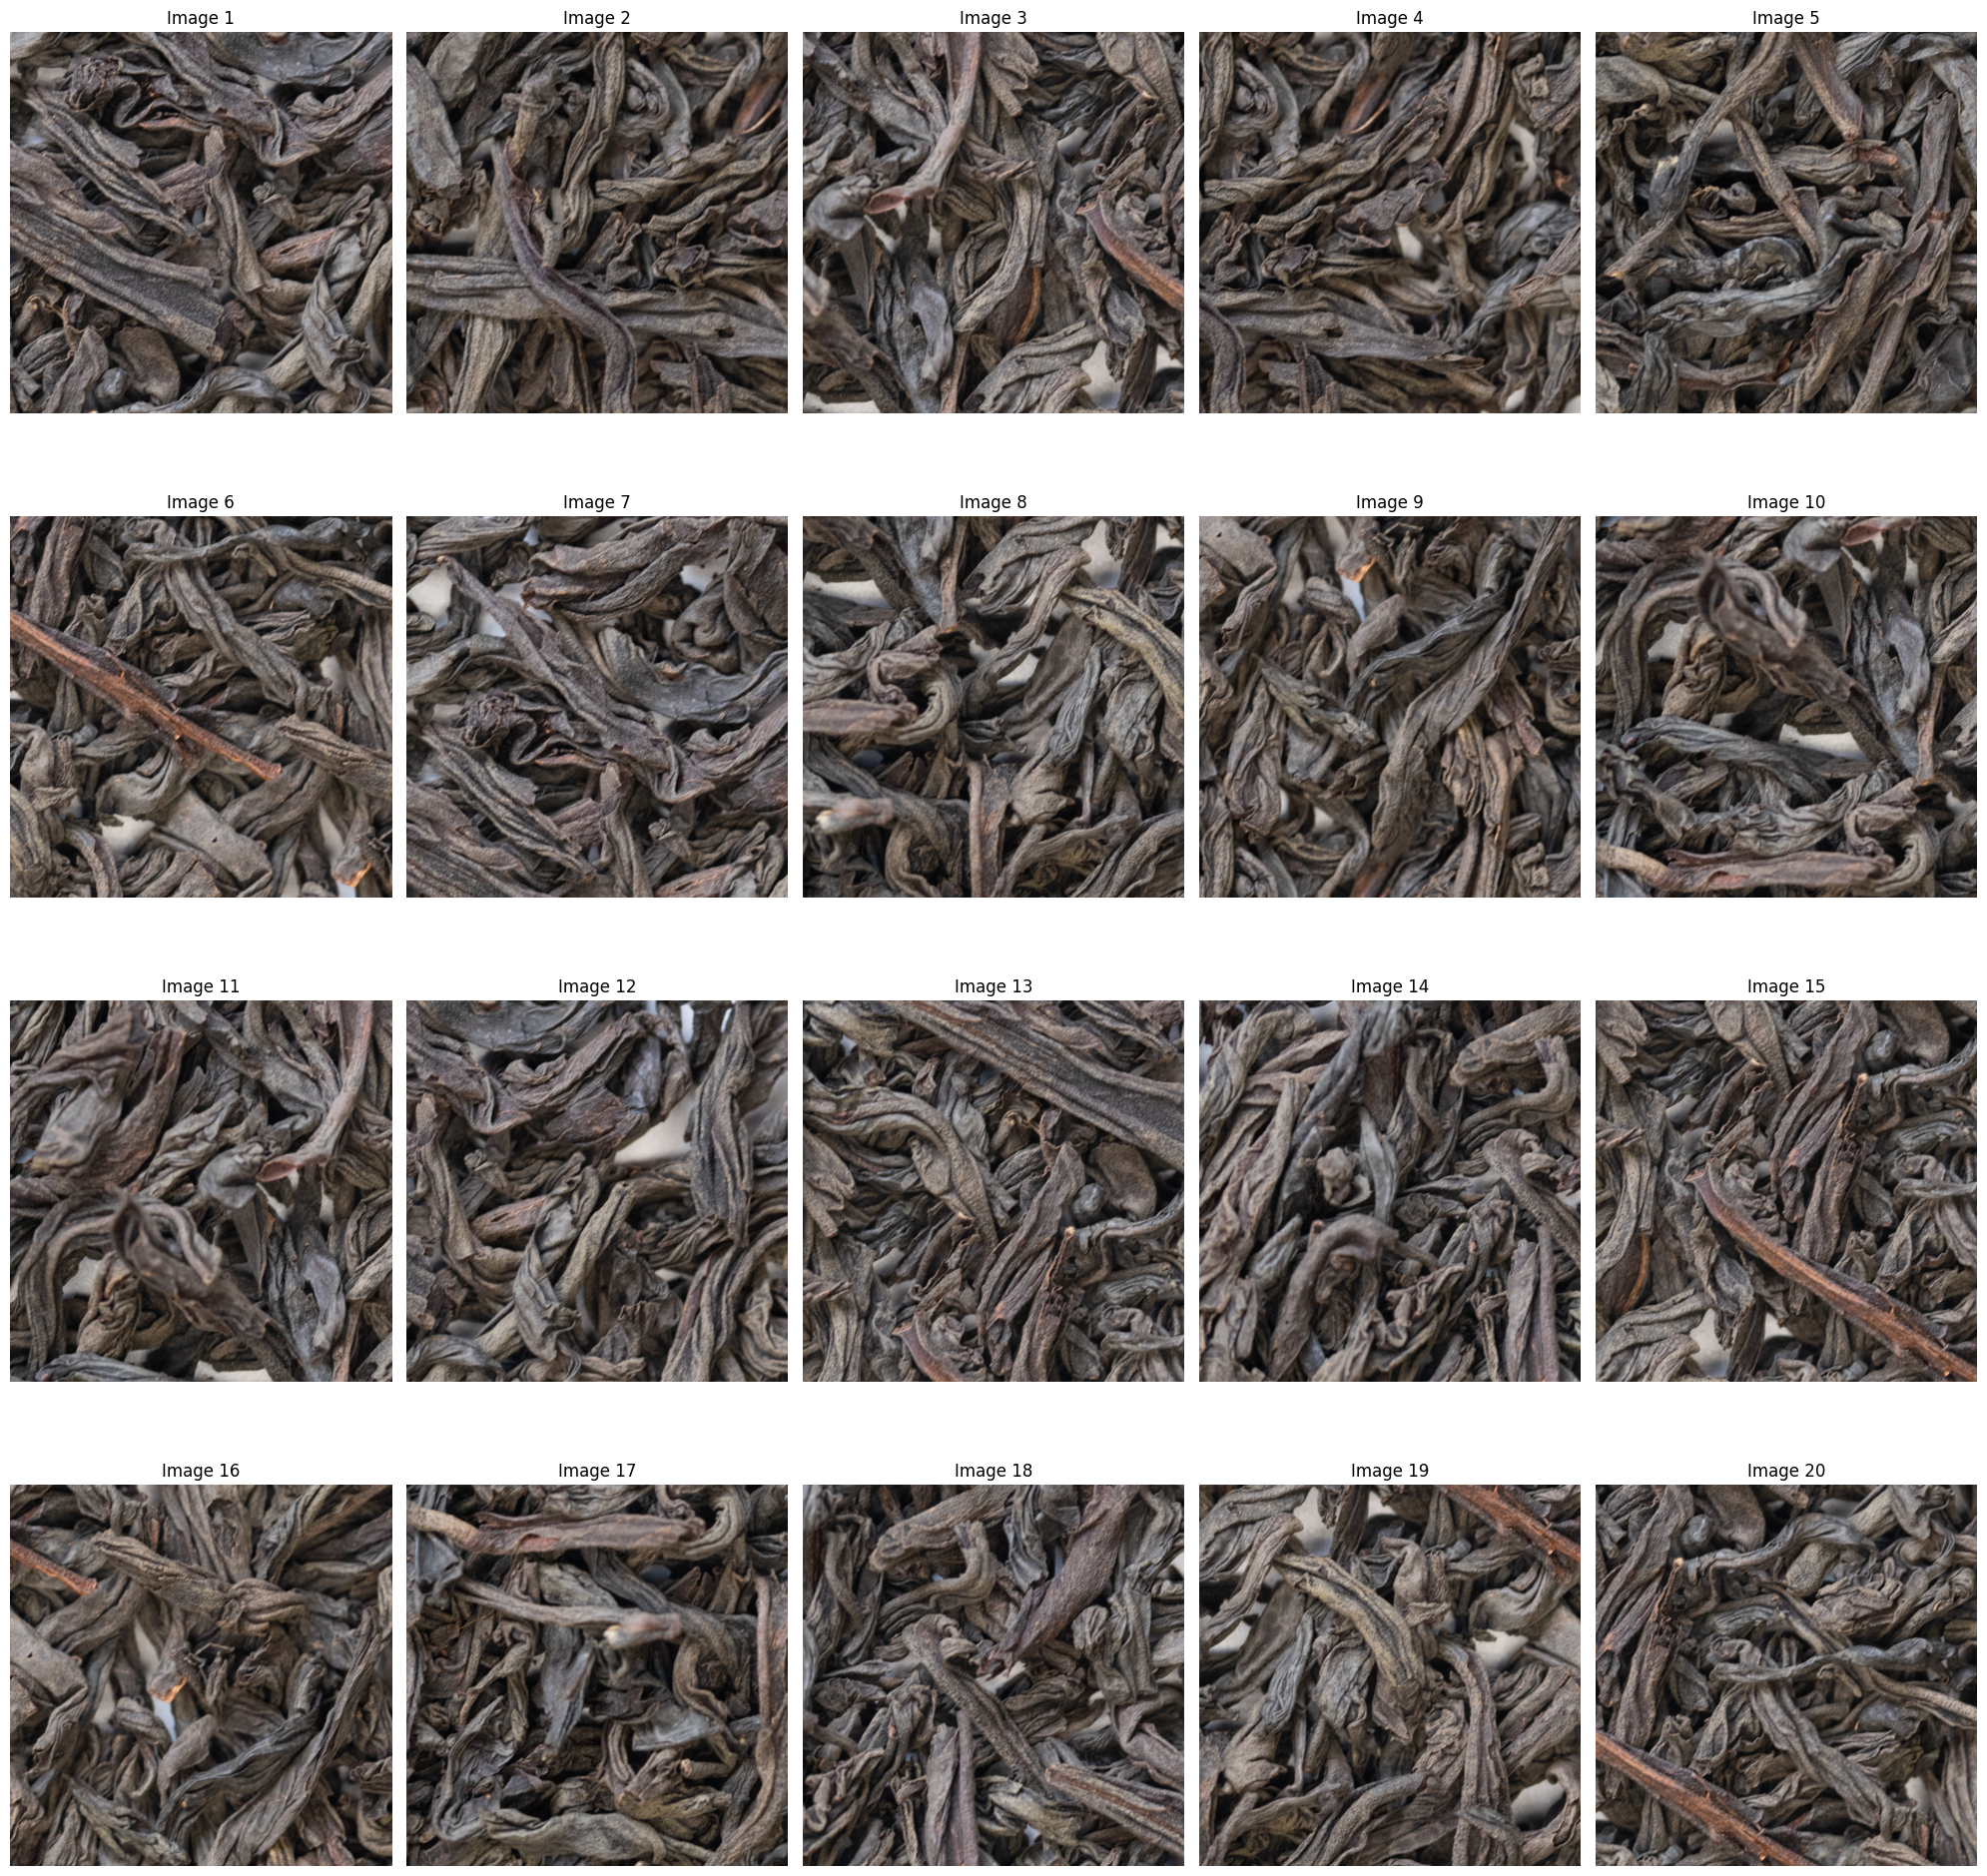

In [9]:
# Read the image
image = cv2.imread('F:/Paraqum/New Models/Dataset/Day3/Day3/Edited Photos/OP/Train/D75_7837.jpg')
sampled_images = sample_multiple(image,1200,90,20,False)
# Dummy image generation for demonstration
dummy_images = sampled_images #[np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(9)]
dummy_titles = [f'Image {i+1}' for i in range(len(dummy_images))]
plot_images(dummy_images, titles=dummy_titles, cols=5, figsize=(20, 20))


In [10]:
def generate_random_list(target_sum, random_range):
    """
    Generates a list of random numbers where the sum is equal to a specified target value.

    Args:
        target_sum (int): The target sum that the list of random numbers should reach.
        random_range (int): The upper boundary for each random number generated.

    Returns:
        list: A list of random numbers where the sum is equal to the target sum.
    """
    numbers = []
    current_sum = 0

    while current_sum < target_sum:
        # Calculate the maximum possible random number to avoid exceeding the target_sum
        max_possible = min(random_range, target_sum - current_sum)
        
        # Generate a random number
        random_number = random.randint(1, max_possible)
        
        # Add the random number to the list
        numbers.append(random_number)
        
        # Update the current sum
        current_sum += random_number

    return numbers


def generate_random_sampled_images(image,window_size,max_rotation_angle,num_of_samples,white_percentage_filter = True,random_angle=False,random_scale_factor = 0):
    """
    Generates a set of sampled images based on the given center, size, and rotation angle.
    args:
        image: The image.
        window_size (int): The side length of the square window(Pixels).
        max_rotation_angle (float): The maximum rotation angle in degrees.
        num_of_samples (int): The total number of sampled images.
        white_percentage_filter (bool, optional): Whether or not to use white pixel percentage filter. Default => Use.
        random_angle (bool, optional): Whether or not to randomly rotate images. Default => Not.
        random_scale_factor : zero if no need to use, applied window size will be random in range of [window_size+-scale_factor*window_size]
    """
    sampled_images = []
    
    # If the random angle is 'False'
    if random_angle == False:
        sampled_images = sample_multiple(image,window_size,max_rotation_angle,num_of_samples,white_percentage_filter,random_scale_factor)

    else:     
        # Randomized Image Generation
        # To verify same type of generation never exceed 10% of total samples
        random_range = math.ceil(num_of_samples*0.1)
        # Generate random sample count list which sums to the 'num_of_samples'
        random_sample_list = generate_random_list(num_of_samples,random_range)
        # Generate random angle list
        random_angle_list = [random.randint(0, max_rotation_angle - 1) for _ in range(len(random_sample_list))]
        
        # Generate Images
        for i in range(len(random_sample_list)):
            sampled_images_temp = sample_multiple(image,window_size,random_angle_list[i],random_sample_list[i],white_percentage_filter,random_scale_factor)
            sampled_images+=sampled_images_temp          
            
            #dummy_images = sampled_images_temp #[np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(9)]
            #dummy_titles = [f'Image {i+1}' for i in range(len(dummy_images))]
            #plot_images(dummy_images, titles=dummy_titles, cols=3, figsize=(15, 10))
                    
    # Return the set
    return sampled_images
        

In [11]:
# Color Filters
def clahe_white_balance(image):
    # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply White Balance
    result = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(result)
    
    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel back with a and b channels
    result = cv2.merge((l,a,b))
    
    # Convert back to RGB color space
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    
    return result


def gray_scaled(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return  gray_image

def hsv_colored(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return hsv_image

def lab_colored(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    return lab_image

def apply_color_jitter(image, brightness=0, contrast=1, saturation=1, hue=0):
    """
    Applies color jittering to an image.
    
    Parameters:
        image (numpy.ndarray): Input image.
        brightness (int or float): Factor to adjust brightness (-255 to 255).
        contrast (int or float): Factor to adjust contrast (1.0 means no change).
        saturation (int or float): Factor to adjust saturation (1.0 means no change).
        hue (int or float): Factor to adjust hue (-180 to 180).
    
    Returns:
        numpy.ndarray: Color jittered image.
    """

    # Convert image to float32 for precision
    image = np.array(image, dtype=np.float32)

    # Adjust brightness
    if brightness != 0:
        image += brightness

    # Adjust contrast
    if contrast != 1:
        image = cv2.convertScaleAbs(image, alpha=contrast, beta=0)

    # Convert to HSV to adjust saturation and hue
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Adjust saturation
    if saturation != 1:
        hsv_image[:, :, 1] = cv2.convertScaleAbs(hsv_image[:, :, 1], alpha=saturation, beta=0)

    # Adjust hue
    if hue != 0:
        hsv_image[:, :, 0] = (hsv_image[:, :, 0].astype(int) + hue) % 180
        hsv_image[:, :, 0] = np.clip(hsv_image[:, :, 0], 0, 179).astype(np.uint8)

    # Convert back to BGR
    jittered_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Clip the values to ensure they're within [0, 255] and convert back to uint8
    jittered_image = np.clip(jittered_image, 0, 255).astype(np.uint8)

    return jittered_image

In [12]:
def rescale_image(image, resolutions):
    """
    Change the resolution of an image to the specified dimensions and saves the result.

    args:
        image (numpy.ndarray): The image to be rescaled.
        resolutions (tuple): The dimensions of the image to be rescaled.
    """
    new_width, new_height = resolutions
    
    # Resize the image to the new dimensions
    resized_image = cv2.resize(image, (new_width, new_height))
    
    return resized_image

In [46]:


def process_single_image(image_address, re_scale = False, re_scaling_resolutions = (512,512), starting_index = 0, save_directory='Labeled/', num_of_samples = 64, window_size = 1024, max_rotation_angle = 45, color_matching = 'None', white_filter = False, random_scale_factor = 0, color_jitter = False,
                         jlitter_variation_percentages=None):
    """
    Processes a single image.
    args:
        image_address : The address of the image.
        re_scale (bool, optional): Whether or not to re-scale the image.
        re_scaling_resolutions (tuple, optional): The resolution of the image in pixels.
        starting_index (int, optional): The starting index of the image.
        save_directory (str): The directory to save the image. Example: 'Labeled/'
        num_of_samples (int, optional): The number of samples per image.
        window_size(int, optional): The size of the window.
        max_rotation_angle (int, optional): The maximum rotation angle of the image.
        color_matching (str, optional): The color matching algorithm to use. [None, clahe_white_balance,gray_scaled,hsv_colored,lab_colored]
        white_filter (bool, optional): Whether or not to apply white background percentage check to generated images.
        random_scale_factor : zero if no need to use, applied window size will be random in range of [window_size+-scale_factor*window_size]
        color_jitter (bool, optional): Whether or not to apply color jittering to an image.
        jlitter_variation_percentages (2D list): The range of the jlitter ranges if above is True.(as a variation factor as a percentage)
                                  [brightness,contrast,saturation,hue]
        
    return:
        Save Processed Images
    """
    global image_index

    # Extract the image name
    if jlitter_variation_percentages is None:
        jlitter_variation_percentages = [2, 1, 0, 0]
    image_name = os.path.basename(image_address)
    # Remove the file extension
    image_name_without_extension = os.path.splitext(image_name)[0]
    # Get the image grade
    #grade = re.split(r'\s+', image_name_without_extension)[2]
    #grade = image_name_without_extension.split(' ')[2]   <- This may not work if image name seperation is done with multiple spaces
    
    # Read the image
    image = cv2.imread(image_address)
    
    # If color Jlitter is required
    if color_jitter:
        # Get a random brightness factor
        random_brightness_val = round(random.uniform(-255*jlitter_variation_percentages[0]/100,255*jlitter_variation_percentages[0]/100),2) 
        random_contrast = round(random.uniform(1-1*jlitter_variation_percentages[1]/100,1+1*jlitter_variation_percentages[1]/100),2)
        random_saturation = round(random.uniform(1-1*jlitter_variation_percentages[2]/100,1+1*jlitter_variation_percentages[2]/100),2)
        random_hue = round(random.uniform(-180*jlitter_variation_percentages[3]/100,180*jlitter_variation_percentages[3]/100),2)
        image= apply_color_jitter(image,random_brightness_val,random_contrast,random_saturation,random_hue)
    
    # Change the color-space
    if color_matching == 'clahe_white_balance':        
        image = clahe_white_balance(image)
    elif color_matching == 'gray_scaled':
        image = gray_scaled(image)
    elif color_matching == 'hsv_colored':
        image = hsv_colored(image)
    elif color_matching == 'lab_colored':
        image = lab_colored(image)
    
    # Sample Image
    sampled_images = generate_random_sampled_images(image,window_size,max_rotation_angle,num_of_samples,white_filter,True,random_scale_factor=random_scale_factor)
    
    #Save images
    for i in range(len(sampled_images)):
        # Check if the directory exists, and create it if not
        save_path = save_directory+"/"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_path += image_name_without_extension+ " " + "OPA" + " " +str(i+starting_index)+".jpg"
        # If rescale is required
        if re_scale:
            sampled_images[i] = rescale_image(sampled_images[i],re_scaling_resolutions)
        cv2.imwrite(save_path,sampled_images[i])
        print(save_path)

        
    print("Sampling Done! Saved images to",save_directory)
    
    
    

 


In [47]:
image_index =0
        
def process_all_images(captured_directory,save_directory,start_index = 0):
    """
    Processes all images.
    args:
        captured_directory (str): The directory to save the images. Example: 'Labeled/'
        save_directory (str): The directory to save the images. Example: 'Labeled/' 
    """
    global image_index

    print(image_index)
    
    #Change the settings as required
    sample_no = 2
    image_index = image_index + start_index
    num_of_samples = 20  #number of samples per image
    re_scale = True  #True
    re_scale_res = (512,512)
    window_size = 1024    #2000
    max_rotation_angle=180
    color_matching ='None' #'None' #'gray_scaled' #lab_colored'
    white_filter = True
    random_scale_factor = 0   #0.05-> means +/- 5% of the window size
    color_jitter = True
    variation_percentages = [3,3,0,0]  # 7 7 7 4
    
    for image in os.listdir(captured_directory):
        # Get the image grade
        #id = int(os.path.splitext(image)[0].split(' ')[-1][1:-1])*1000
        
        process_single_image(captured_directory+image,re_scale,re_scale_res,image_index,save_directory,num_of_samples,window_size,max_rotation_angle,color_matching,white_filter,color_jitter = color_jitter,jlitter_variation_percentages=variation_percentages,random_scale_factor =random_scale_factor)
        image_index += num_of_samples

        print(image_index)
        

        

        


In [48]:
captured_directory = 'F:/Paraqum/New Models/Dataset/Day 2/0 Original Exposure Color Corrected/Selected Classes/OPA/Val/'
sampled_save_directory = 'F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA'
while image_index < 90:
    process_all_images(captured_directory,sampled_save_directory)

0
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 0.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 1.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 2.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 3.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 4.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 5.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 6.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 7.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 8.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 9.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 10.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 11.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 12.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 13.jpg
F:/Paraqum/New Models/Dataset/Day 2/Draft/OPA/D75_7741 OPA 14.jpg
F:/Paraqum/New Mod

In [49]:
import os
import random
import shutil

def balance_subfolder_images(folder_path):
    # List all subfolders and count images in each
    subfolders = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    image_counts = {subfolder: len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]) for subfolder in subfolders}
    
    # Determine the target number of images per subfolder
    min_images = min(image_counts.values())
    
    for subfolder, count in image_counts.items():
        images = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
        
        if count > min_images:
            # Randomly select and remove excess images
            images_to_remove = random.sample(images, count - min_images)
            for image in images_to_remove:
                os.remove(os.path.join(subfolder, image))
        
        elif count < min_images:
            # Randomly copy images to meet the target count
            images_to_copy = random.choices(images, k=min_images - count)
            for image in images_to_copy:
                source = os.path.join(subfolder, image)
                destination = os.path.join(subfolder, f"copy_{image}")
                shutil.copy(source, destination)
    print(min_images)
    print("All subfolders have been balanced to contain the same number of images.")

# to Balance The Dataset
folder_path = 'Dataset/Day 2/Draft/'
balance_subfolder_images(folder_path)

200
All subfolders have been balanced to contain the same number of images.
